In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


## The data here is ↓↓↓ collected by the best hyperparamters set, and I accidentally repeating runing 10 times instead of 5 times(Mentioned in the task requirement). But I do not think this is a problem. 

In [50]:
# Load the CSV files
mu_plus_df = pd.read_csv('mu_plus_lambda_metrics.csv')
mu_comma_df = pd.read_csv('mu_comma_lambda_metrics.csv')

### - AVG of Fitness_avg vs. Generations for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

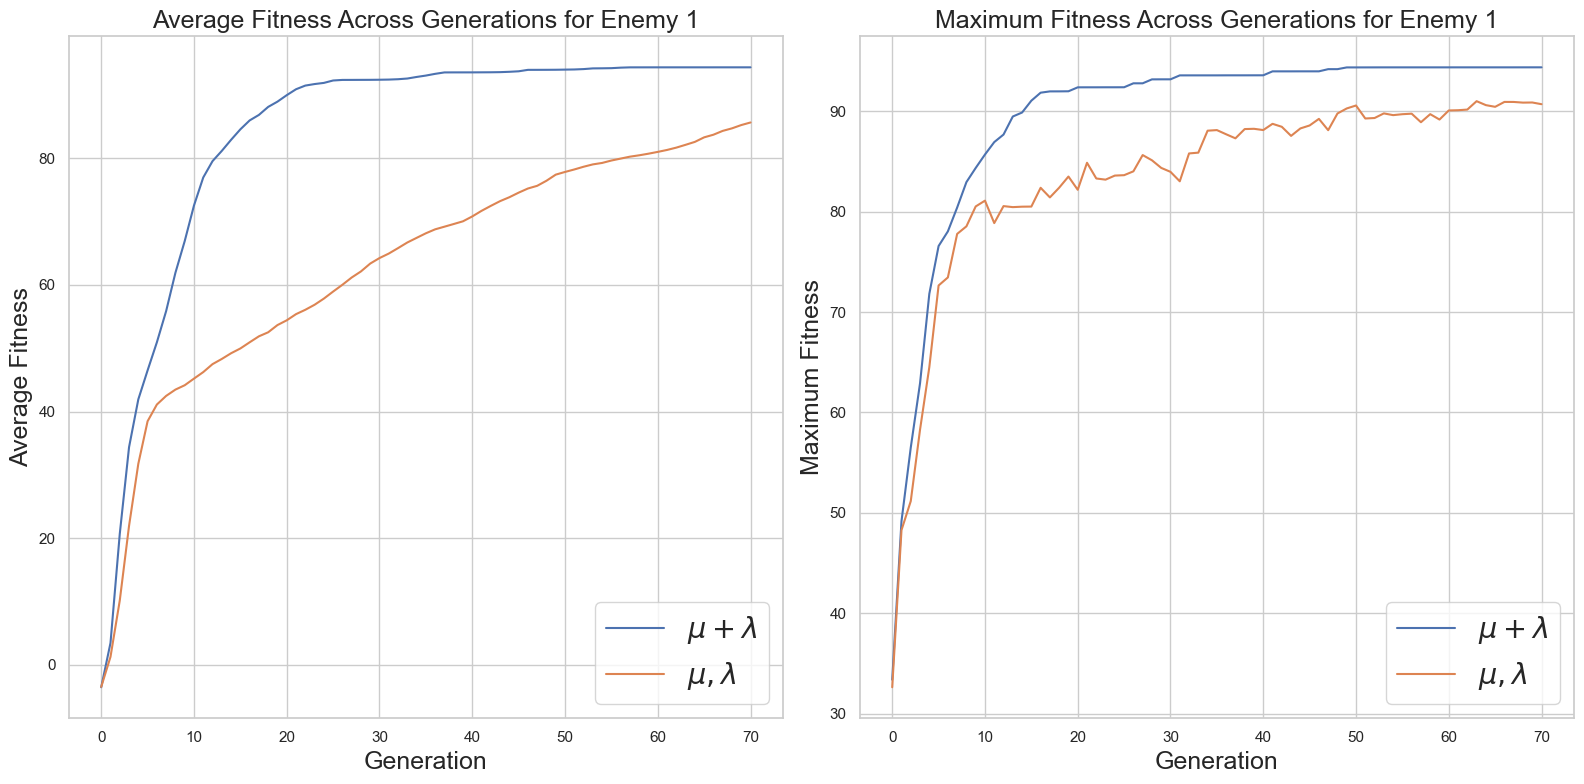

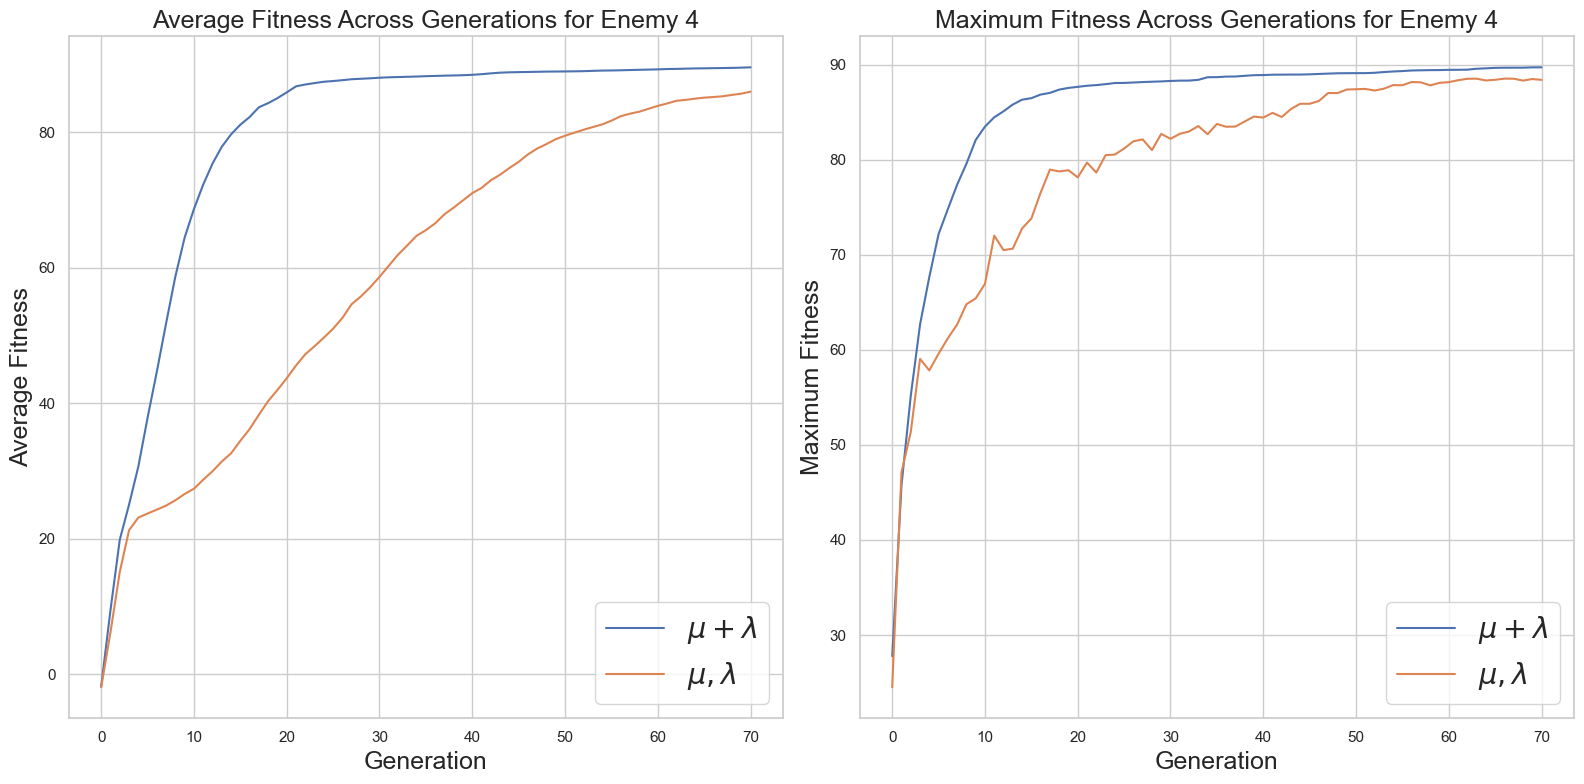

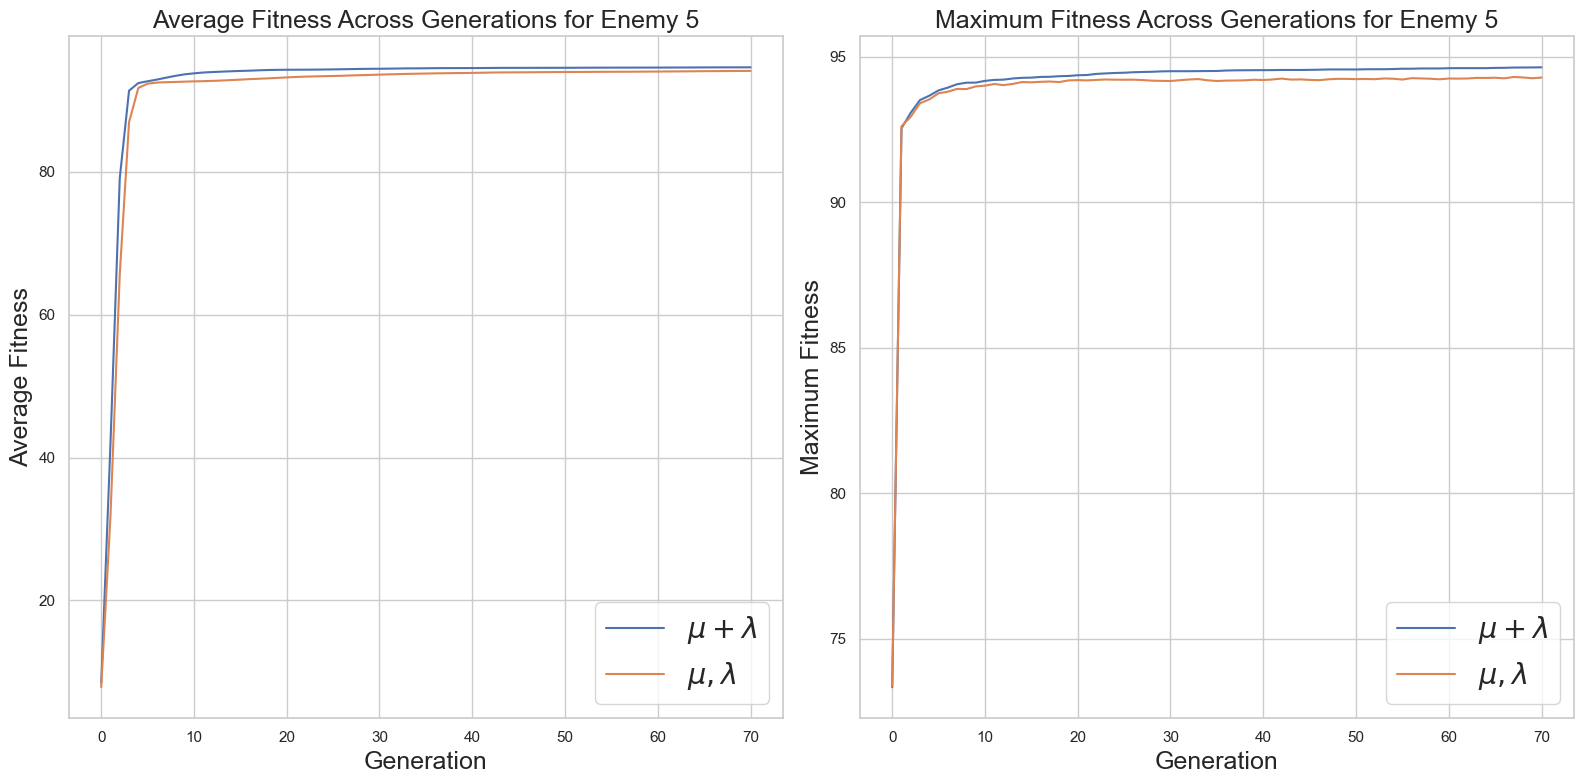

In [51]:
mu_plus_df['Algorithm'] = f'$\mu + \lambda$'
mu_comma_df['Algorithm'] = f'$\mu , \lambda$'

combined_df = pd.concat([mu_plus_df, mu_comma_df])

# Group by 'Enemy', 'Generation', and 'Algorithm', then calculate the mean and standard deviation
grouped_df = combined_df.groupby(['Enemy', 'Generation', 'Algorithm']).agg({
    'Fitness_Avg': ['mean', 'std'],
    'Fitness_Max': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex for easier plotting
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
grouped_df.rename(columns={'Enemy_': 'Enemy', 'Generation_': 'Generation', 'Algorithm_': 'Algorithm'}, inplace=True)

enemies = grouped_df['Enemy'].unique()
for enemy in enemies:
    enemy_data = grouped_df[grouped_df['Enemy'] == enemy]
    
    plt.figure(figsize=(16, 8))
    
    # Plot for average fitness
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Generation', y='Fitness_Avg_mean', hue='Algorithm', data=enemy_data, style='Algorithm', markers=False, dashes=False)
    plt.title(f'Average Fitness Across Generations for Enemy {enemy}', fontsize=18)
    plt.xlabel('Generation', fontsize=18)
    plt.ylabel('Average Fitness', fontsize=18)
    plt.legend(loc = 'lower right', fontsize= 'xx-large')
    
    # Plot for maximum fitness
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Generation', y='Fitness_Max_mean', hue='Algorithm', data=enemy_data, style='Algorithm', markers=False, dashes=False)
    plt.title(f'Maximum Fitness Across Generations for Enemy {enemy}', fontsize=18)
    plt.xlabel('Generation', fontsize=18)
    plt.ylabel('Maximum Fitness', fontsize=18)

    plt.legend(loc = 'lower right', fontsize= 'xx-large')
    plt.tight_layout()
    plt.show()


### - Comparing the Individual Gain of $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies in Boxplots

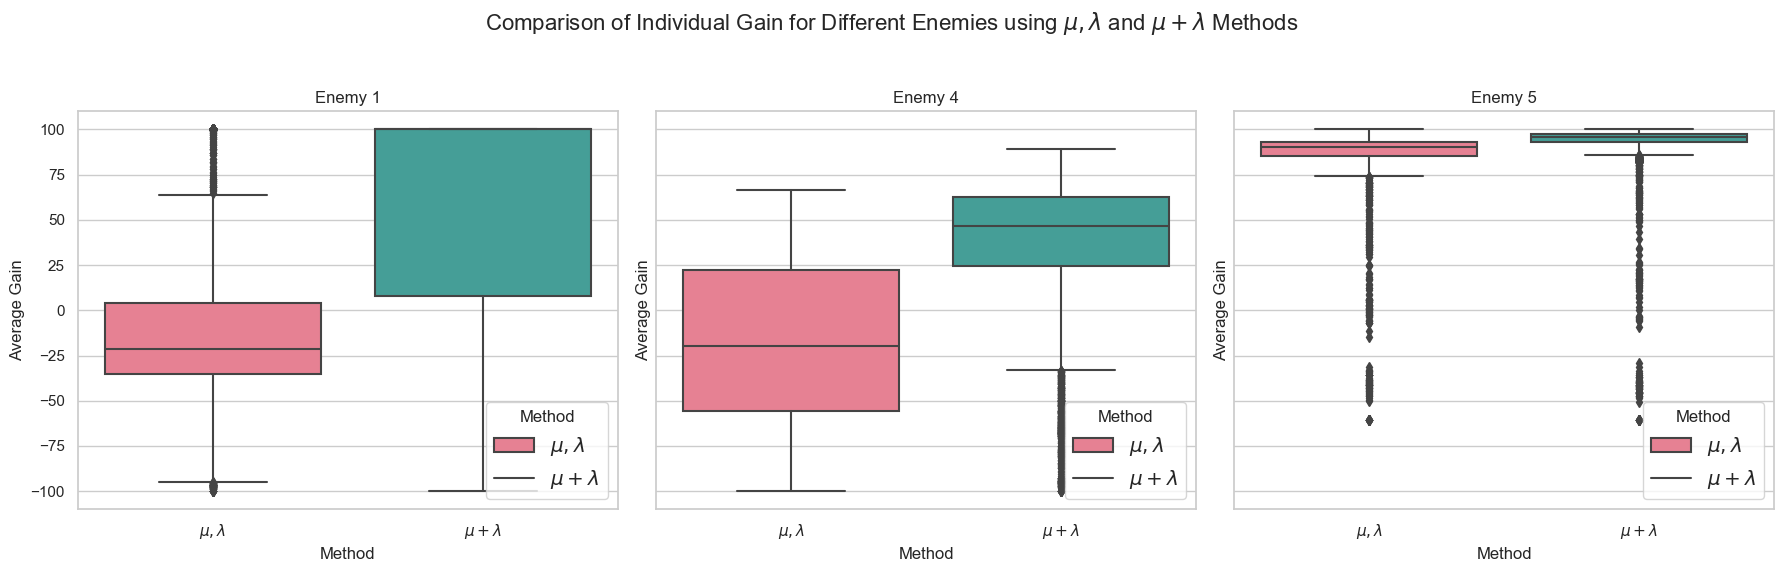

In [52]:
# Filter the data for Gain_Avg and Enemy
mu_comma_lambda_filtered = mu_comma_df[['Enemy', 'Gain_Avg']]
mu_plus_lambda_filtered = mu_plus_df[['Enemy', 'Gain_Avg']]

# Add a new column to indicate the method
mu_comma_lambda_filtered['Method'] = r'$\mu, \lambda$'
mu_plus_lambda_filtered['Method'] = r'$\mu + \lambda$'

# Concatenate the two dataframes
combined_df = pd.concat([mu_comma_lambda_filtered, mu_plus_lambda_filtered])

# Create separate box plots for each enemy
unique_enemies = combined_df['Enemy'].unique()
fig, axes = plt.subplots(1, len(unique_enemies), figsize=(18, 6), sharey=True)

# Customize the plots for better visibility
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 2)

# Loop through each unique enemy and create a box plot
for i, enemy in enumerate(unique_enemies):
    ax = axes[i]
    sns.boxplot(x='Method', y='Gain_Avg', data=combined_df[combined_df['Enemy'] == enemy], ax=ax, palette=palette)
    ax.set_title(rf'Enemy {enemy}')
    ax.set_xlabel('Method')
    ax.set_ylabel('Average Gain')
    ax.legend(title='Method', labels=[r'$\mu, \lambda$', r'$\mu + \lambda$'], loc='lower right', fontsize= 'large')
# Add a main title for all subplots
fig.suptitle(r'Comparison of Individual Gain for Different Enemies using $\mu, \lambda$ and $\mu + \lambda$ Methods', fontsize=16)



plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### - Verify if the differences in the average of these means are significant between the groups of best solutions, when comparing two algorithms of an enemy

In [55]:

grouped_mu_plus = mu_plus_df.groupby(['Enemy', 'Simulation'])['Gain_Avg'].mean().reset_index()
grouped_mu_comma = mu_comma_df.groupby(['Enemy', 'Simulation'])['Gain_Avg'].mean().reset_index()


enemies = grouped_mu_plus['Enemy'].unique()  
for enemy in enemies:
    # Filter the data for the current enemy
    data_mu_plus = grouped_mu_plus[grouped_mu_plus['Enemy'] == enemy]['Gain_Avg']
    data_mu_comma = grouped_mu_comma[grouped_mu_comma['Enemy'] == enemy]['Gain_Avg']
    
    # Perform the t-test
    t_stat, p_val = ttest_ind(data_mu_plus, data_mu_comma)
    
    print(f"For Enemy {enemy}, T-statistic: {t_stat}, P-value: {p_val}")


For Enemy 1, T-statistic: 13.637377973747299, P-value: 6.272743668305368e-11
For Enemy 4, T-statistic: 20.399943778321706, P-value: 6.841636570029351e-14
For Enemy 5, T-statistic: 19.630550298306396, P-value: 1.3286502791392117e-13


### Now, like before, These are plots shows the impact of initial diversity of population on converegnce of "fitness_avg"

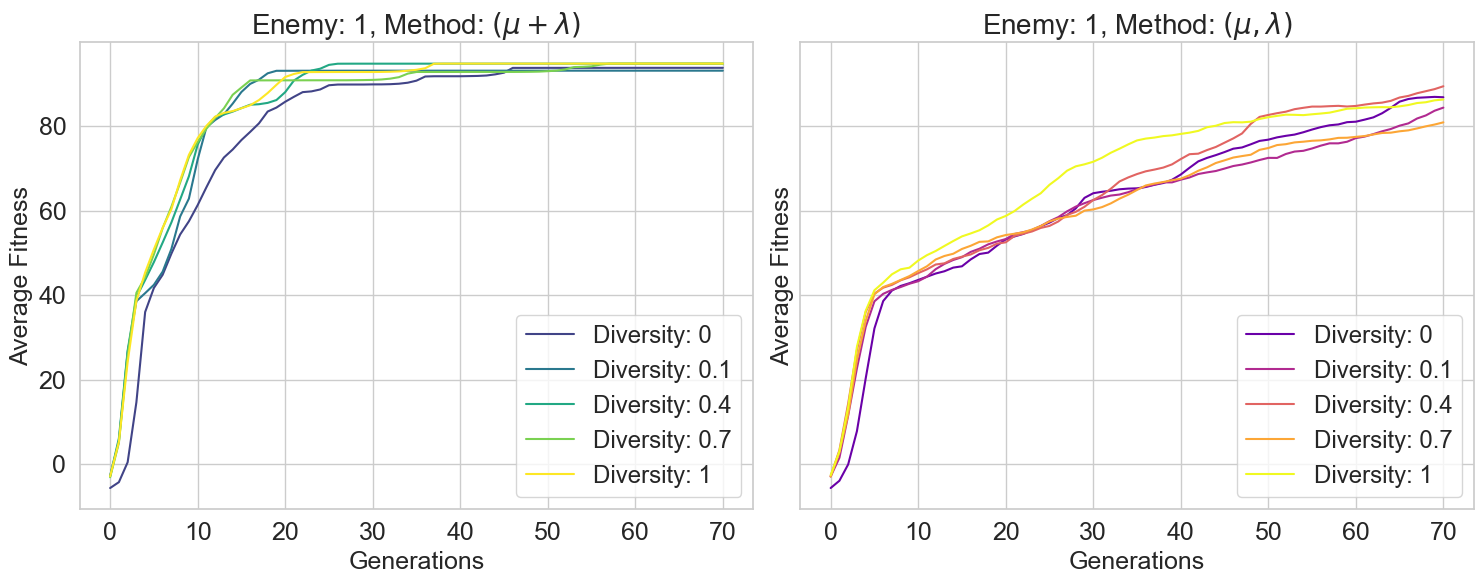

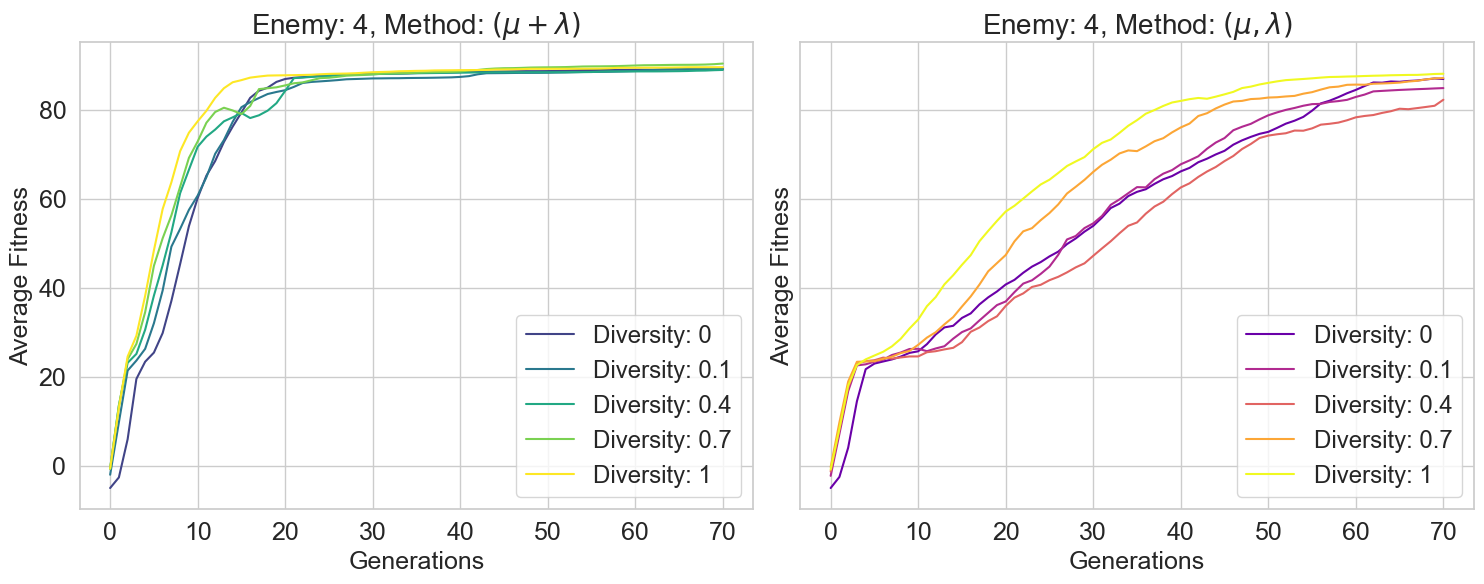

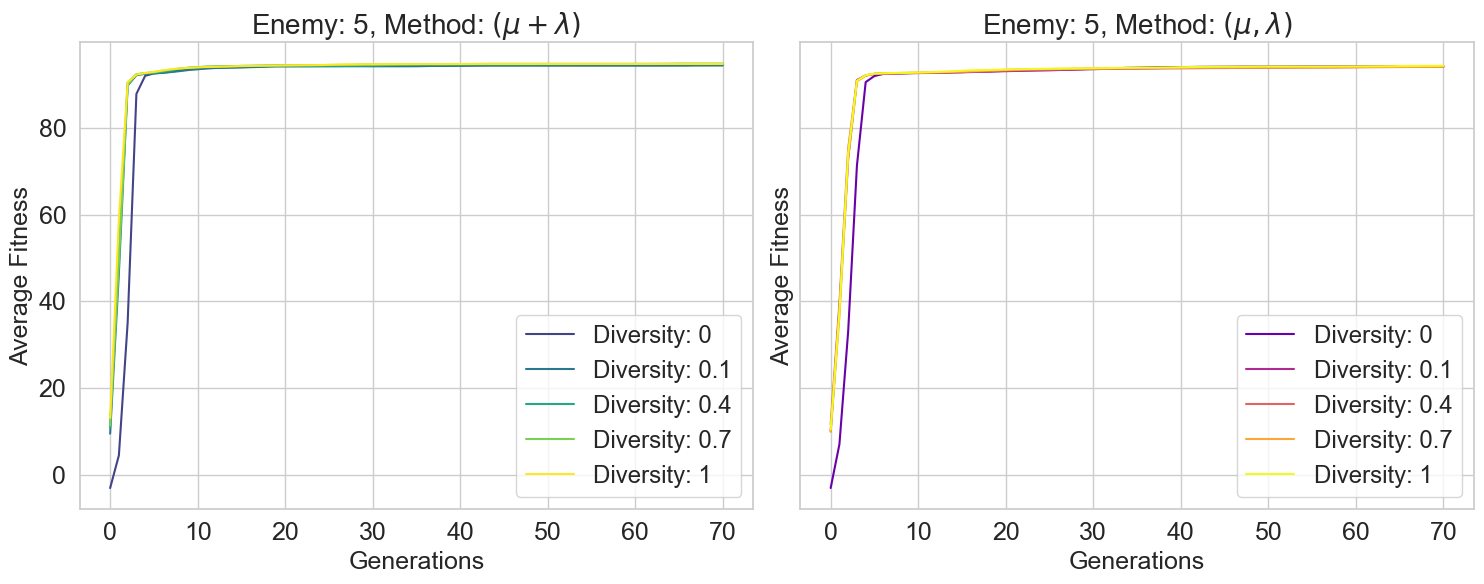

In [78]:
# Initialize color maps for each EA method
cmap_plus = plt.cm.get_cmap('viridis')
cmap_comma = plt.cm.get_cmap('plasma')

diversity_levels = [0, 0.1 , 0.4 ,0.7, 1]
enemies = [1, 4, 5] 

for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    for i, diversity in enumerate(diversity_levels):
        # Generate a color from the color map
        color_plus = cmap_plus((i + 1) / len(diversity_levels))
        color_comma = cmap_comma((i + 1) / len(diversity_levels))
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Calculate the means across all runs
        mean_mu_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Avg'].mean()
        mean_mu_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Avg'].mean()
        
        # Plotting for mu + lambda
        axes[0].plot(mean_mu_plus, label=f'Diversity: {diversity}', color=color_plus)
        
        # Plotting for mu, lambda
        axes[1].plot(mean_mu_comma, label=f'Diversity: {diversity}', color=color_comma)
        
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\mu + \lambda)$', fontsize=20)
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\mu, \lambda)$', fontsize=20)
    
    for ax in axes:
        ax.set_xlabel('Generations', fontsize=18)
        ax.set_ylabel('Average Fitness', fontsize=18)
        ax.legend(loc='lower right', fontsize='x-large')  
        ax.tick_params(axis='both', labelsize=18)
    
    plt.tight_layout()
    plt.show()


### These are plots shows the impact of initial diversity of population on converegnce of "fitness_max"

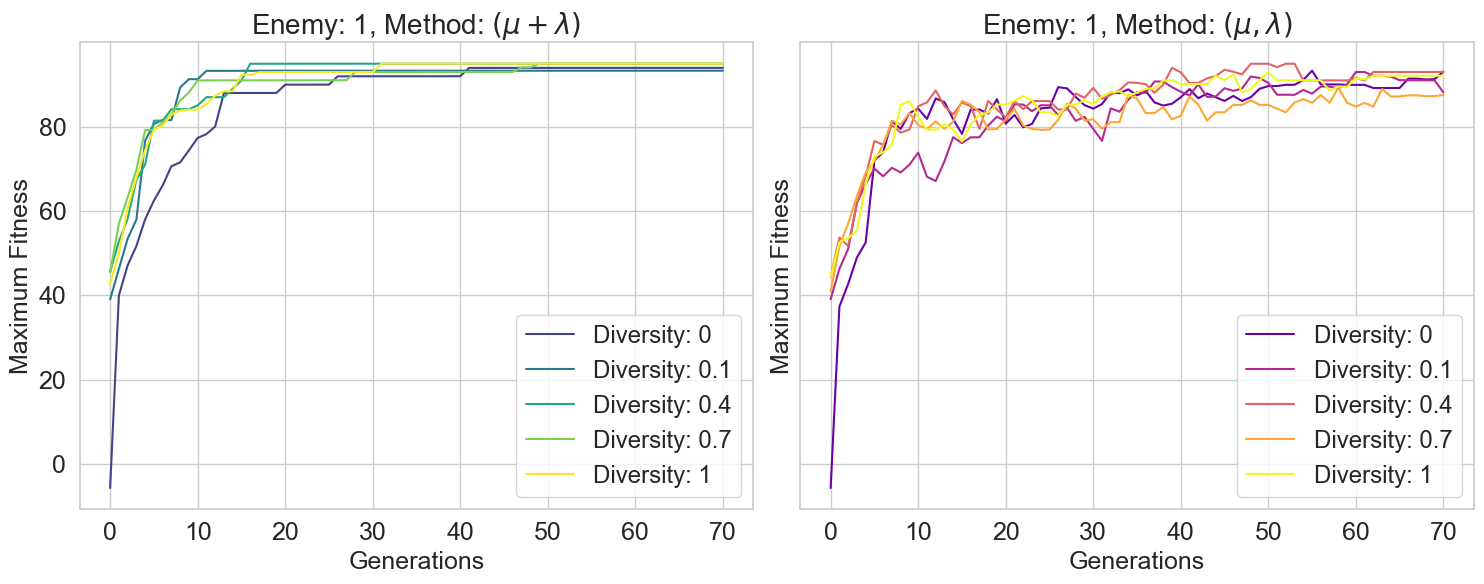

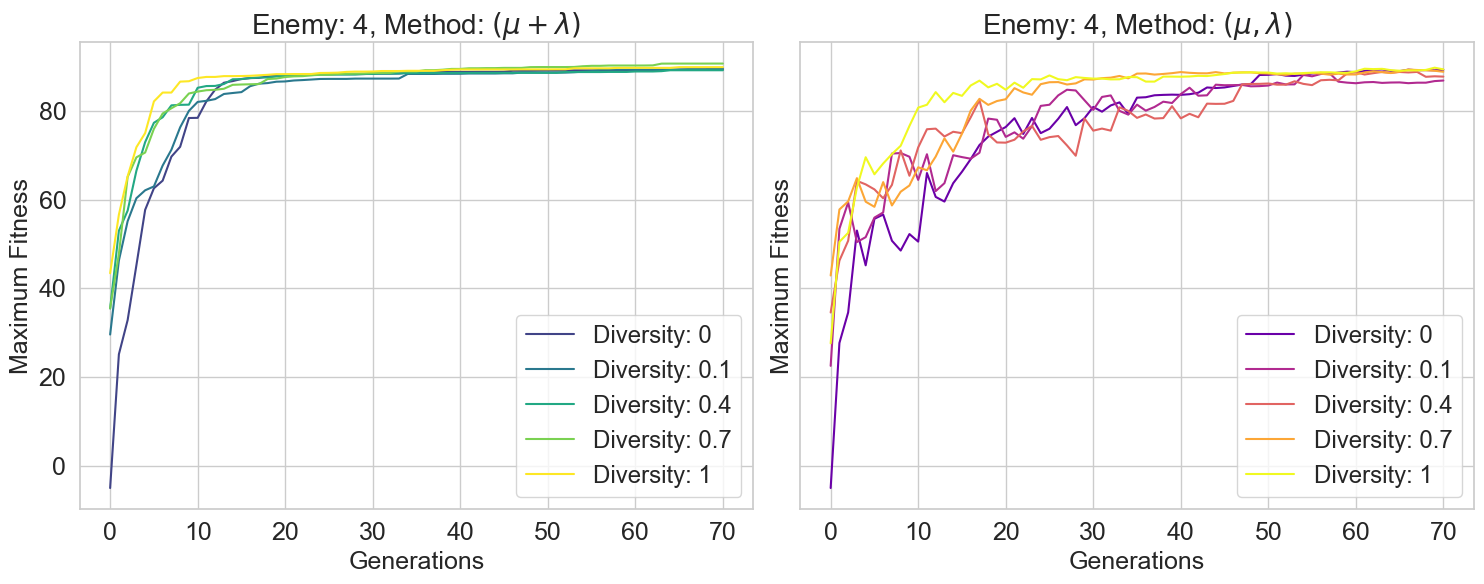

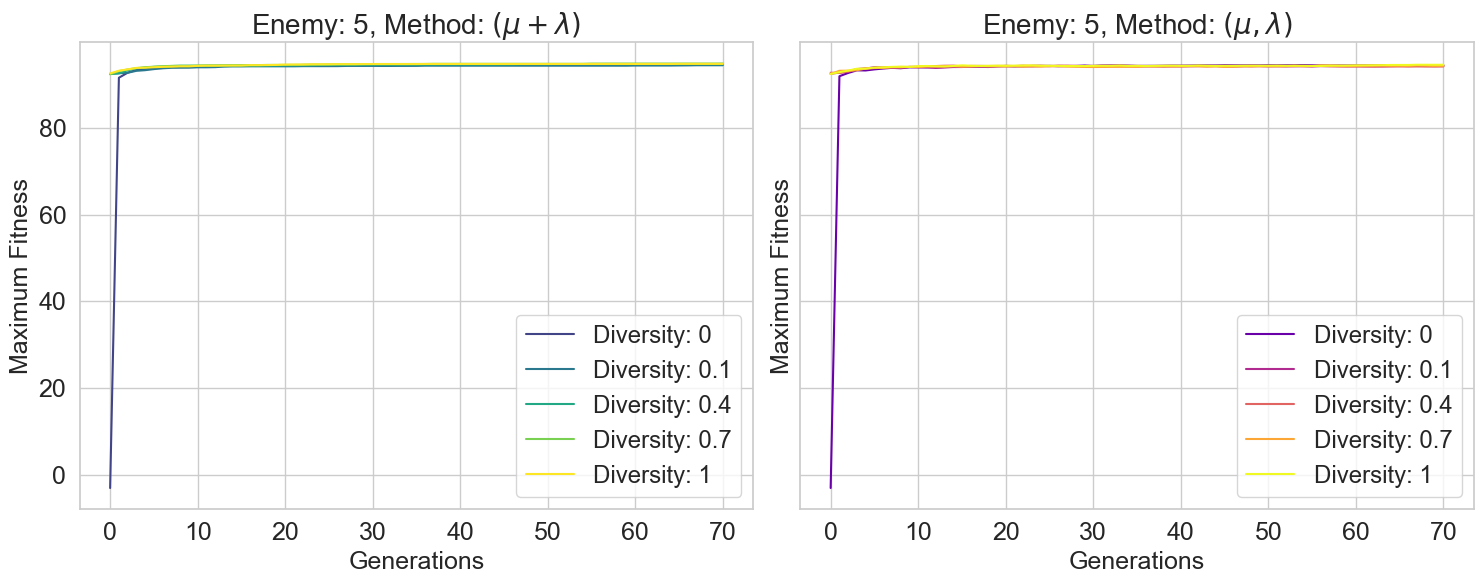

In [77]:
for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    for i, diversity in enumerate(diversity_levels):
        # Generate a color from the color map
        color_plus = cmap_plus((i + 1) / len(diversity_levels))
        color_comma = cmap_comma((i + 1) / len(diversity_levels))
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Calculate the means across all runs
        mean_mu_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Max'].mean()
        mean_mu_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Max'].mean()
        
        # Plotting for mu + lambda
        axes[0].plot(mean_mu_plus, label=f'Diversity: {diversity}', color=color_plus)
        
        # Plotting for mu, lambda
        axes[1].plot(mean_mu_comma, label=f'Diversity: {diversity}', color=color_comma)
        
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\mu + \lambda)$', fontsize=20)
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\mu, \lambda)$', fontsize=20)
    
    for ax in axes:
        ax.set_xlabel('Generations', fontsize=18)
        ax.set_ylabel('Maximum Fitness', fontsize=18)
        ax.legend(loc='lower right', fontsize='x-large')
        ax.tick_params(axis='both', labelsize=18)  
    
    plt.tight_layout()
    plt.show()

### Boxplots of the "Fitness_avg" vs Initial diversity for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

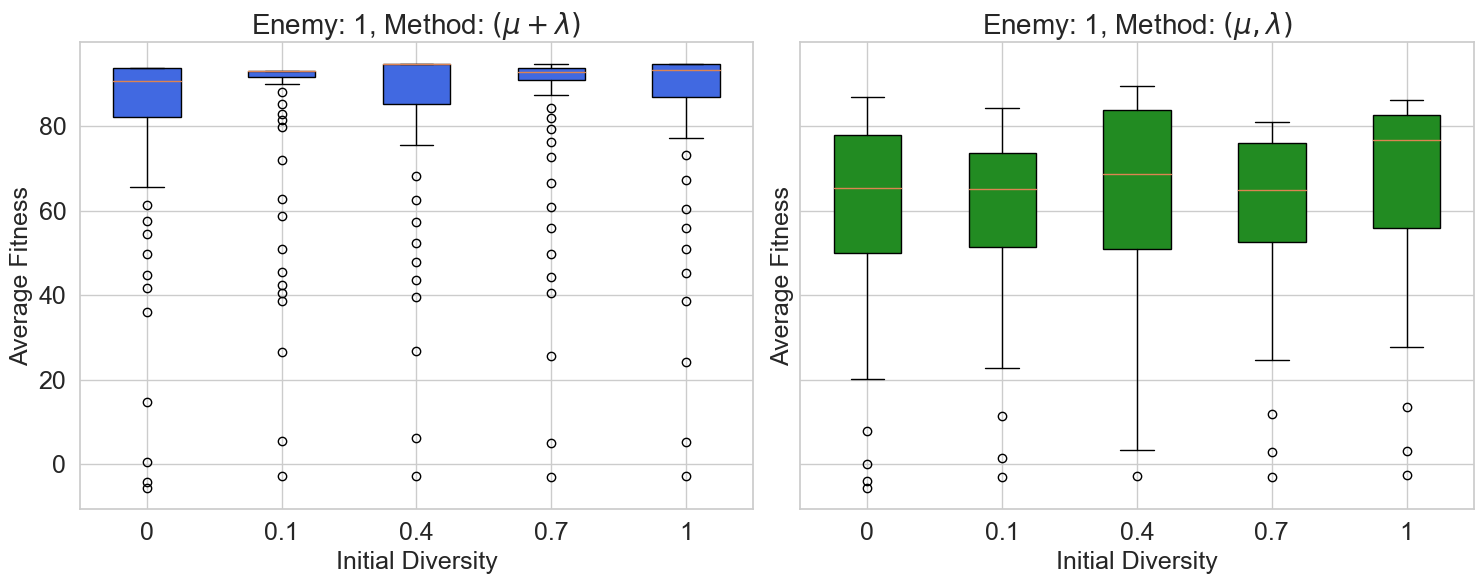

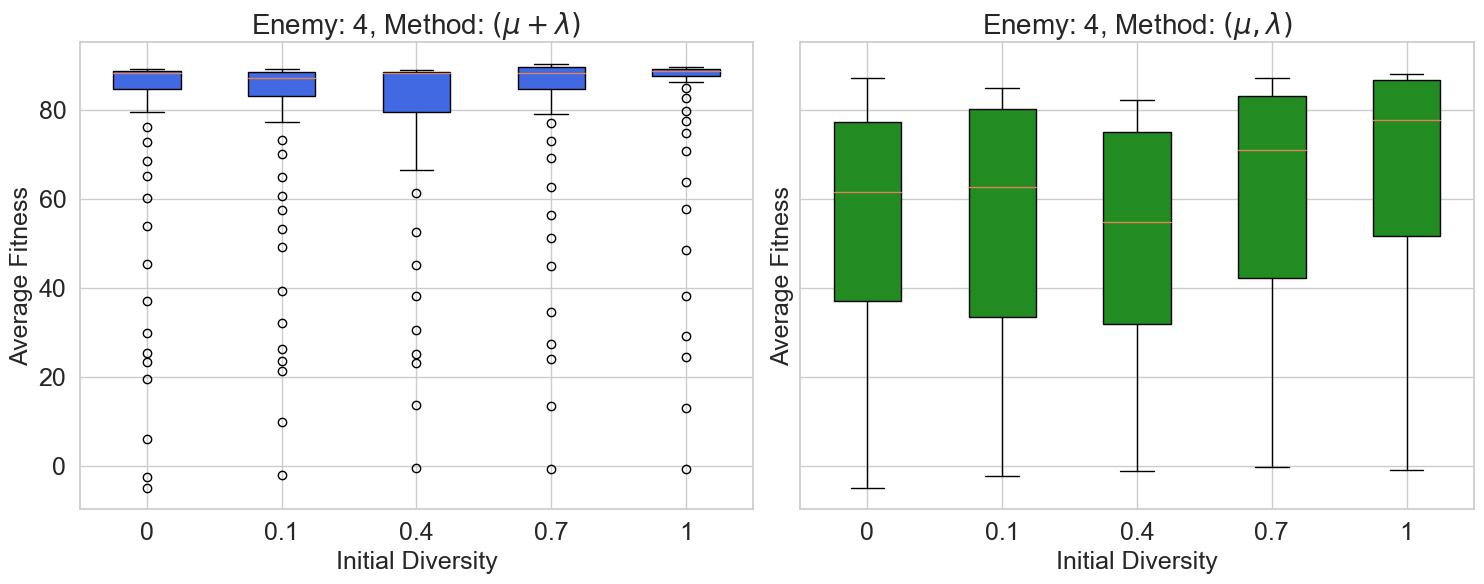

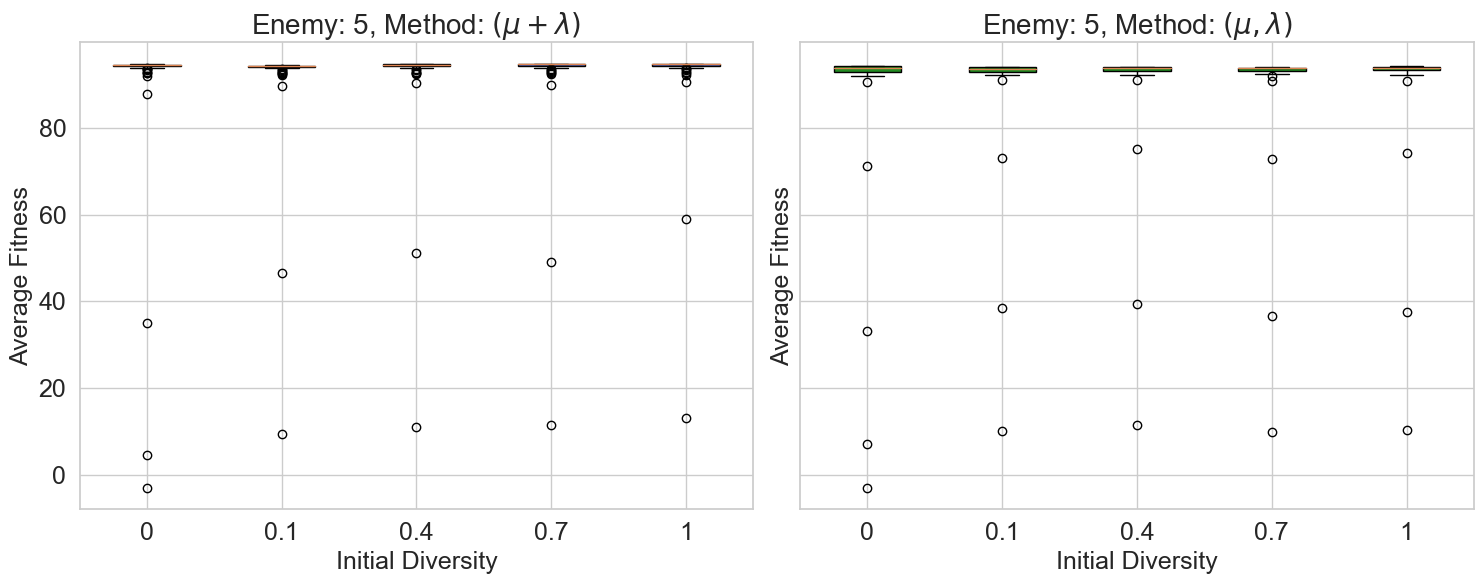

In [82]:
diversity_levels = [0, 0.1 , 0.4 ,0.7, 1]
enemies = [1, 4, 5]

for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    final_fitness_plus = []
    final_fitness_comma = []
    
    for i, diversity in enumerate(diversity_levels):
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Get the final generation fitness average for all runs
        final_gen_fitness_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Avg'].mean().values
        final_gen_fitness_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Avg'].mean().values
        
        final_fitness_plus.append(final_gen_fitness_plus)
        final_fitness_comma.append(final_gen_fitness_comma)
        
    # Plotting for mu + lambda
    axes[0].boxplot(final_fitness_plus, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='royalblue'))
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\\mu + \\lambda)$', fontsize=20)
    
    # Plotting for mu, lambda
    axes[1].boxplot(final_fitness_comma, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='forestgreen'))
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\\mu, \\lambda)$', fontsize=20)
    
    for ax in axes:
        ax.set_xlabel('Initial Diversity', fontsize=18)
        ax.set_ylabel('Average Fitness', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)
    
    plt.tight_layout()
    plt.show()


### Boxplots of the "Fitness_max" vs Initial diversity for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

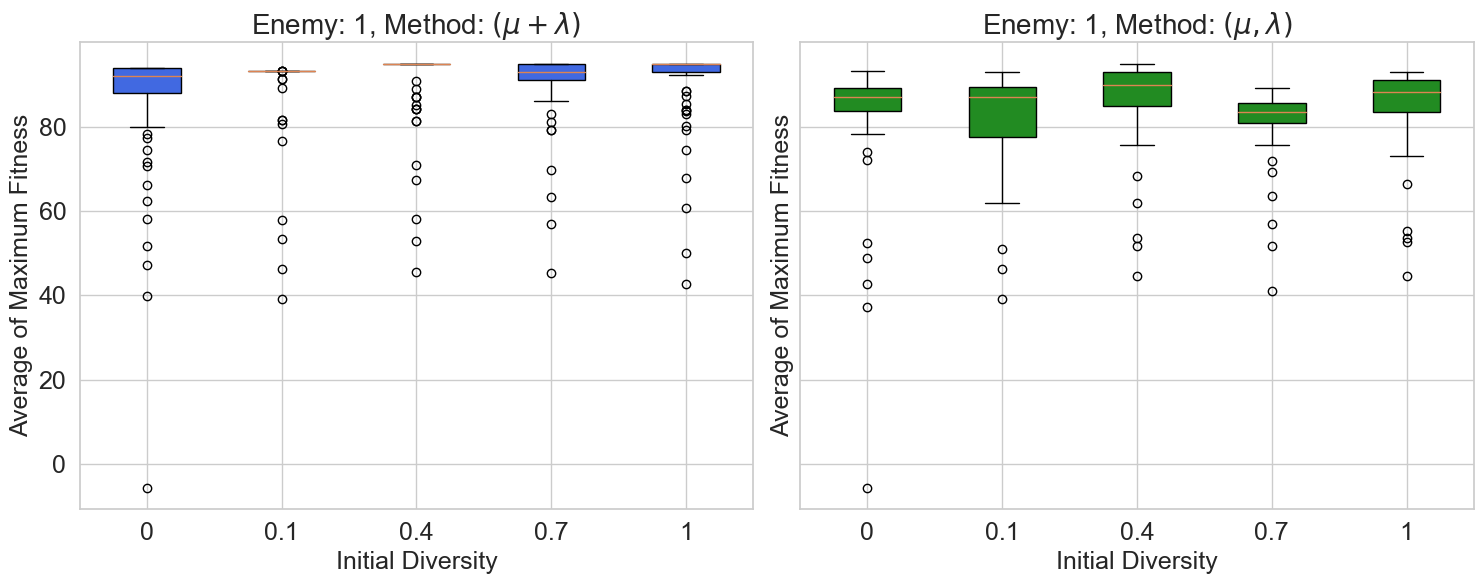

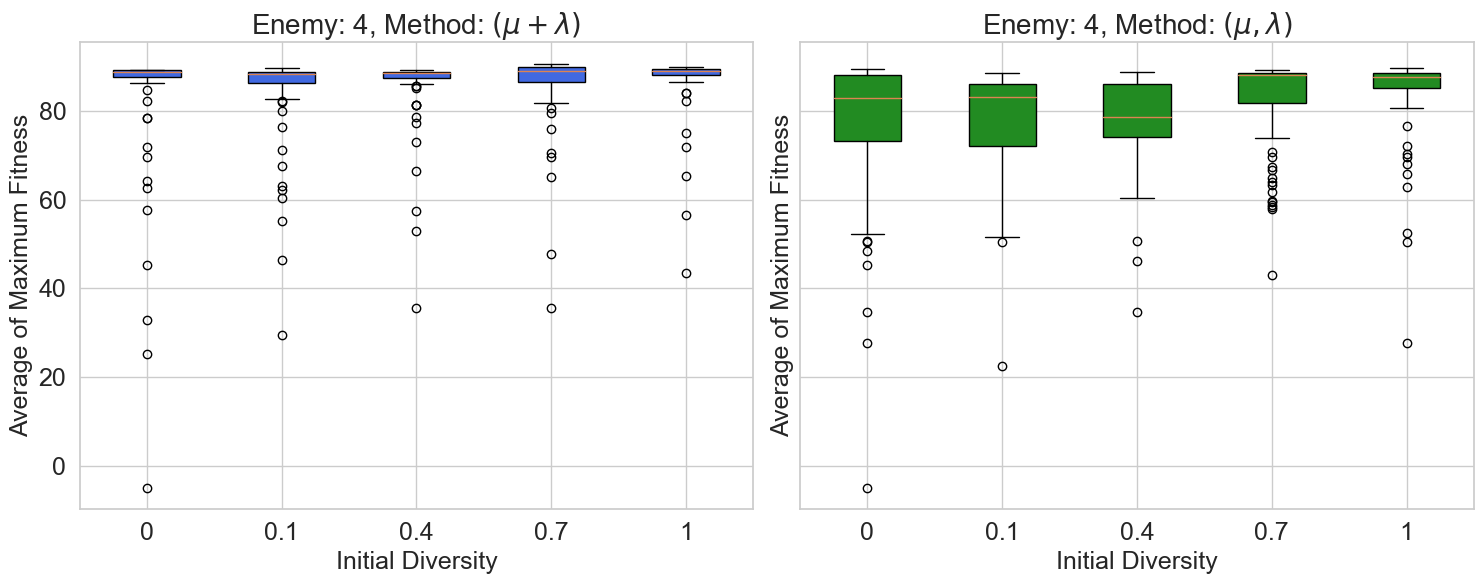

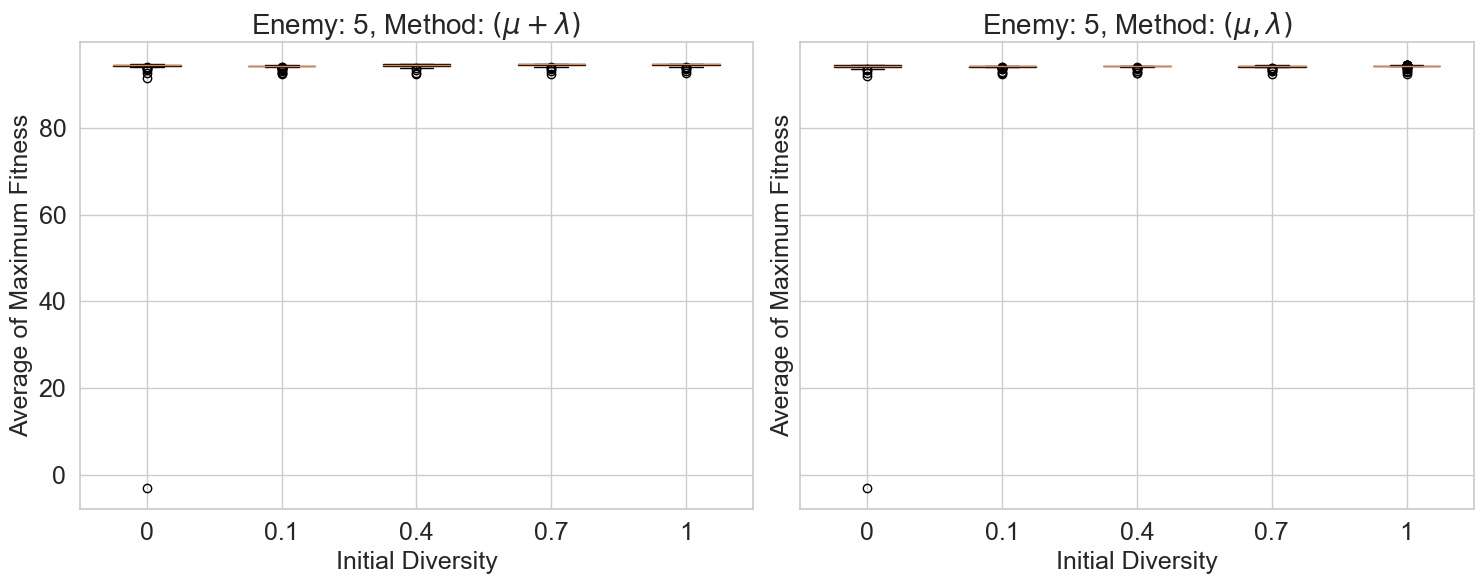

In [81]:

diversity_levels = [0, 0.1 , 0.4 ,0.7, 1]
enemies = [1, 4, 5]

for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    final_fitness_plus = []
    final_fitness_comma = []
    
    for i, diversity in enumerate(diversity_levels):
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Get the final generation fitness average for all runs
        final_gen_fitness_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Max'].mean().values
        final_gen_fitness_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Max'].mean().values
        
        final_fitness_plus.append(final_gen_fitness_plus)
        final_fitness_comma.append(final_gen_fitness_comma)
        
    # Plotting for mu + lambda
    axes[0].boxplot(final_fitness_plus, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='royalblue'))
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\\mu + \\lambda)$', fontsize=20)
    
    # Plotting for mu, lambda
    axes[1].boxplot(final_fitness_comma, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='forestgreen'))
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\\mu, \\lambda)$', fontsize=20)
    
    for ax in axes:
        ax.set_xlabel('Initial Diversity', fontsize=18)
        ax.set_ylabel('Average of Maximum Fitness', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)
    
    plt.tight_layout()
    plt.show()


In [57]:
unique_initial_diversity_mu_comma = mu_comma_df['Initial_Diversity'].unique()
unique_initial_diversity_mu_plus = mu_plus_df['Initial_Diversity'].unique()

(unique_initial_diversity_mu_comma, unique_initial_diversity_mu_plus)

(array([0. , 0.1, 0.4, 0.7, 1. ]), array([0. , 0.1, 0.4, 0.7, 1. ]))

##  Does initial diversity have a significant impact on the "final" value of fitness_avg/max?

In [71]:
# Function to perform t-tests for different initial diversity values
def perform_ttests(df, metric):
    ttest_results = {'Initial_Diversity_1': [], 'Initial_Diversity_2': [], 't_statistic': [], 'p_value': []}
    final_generation = df['Generation'].max()
    
    # Filter data for the final generation
    df_final_gen = df[df['Generation'] == final_generation]
    
    for div1 in unique_initial_diversity_mu_comma:
        for div2 in unique_initial_diversity_mu_comma:
            if div1 >= div2:
                continue
            sample1 = df_final_gen[df_final_gen['Initial_Diversity'] == div1][metric]
            sample2 = df_final_gen[df_final_gen['Initial_Diversity'] == div2][metric]
            
            # Perform t-test
            t_stat, p_val = ttest_ind(sample1, sample2, equal_var=False)
            
            # Store results
            ttest_results['Initial_Diversity_1'].append(div1)
            ttest_results['Initial_Diversity_2'].append(div2)
            ttest_results['t_statistic'].append(t_stat)
            ttest_results['p_value'].append(p_val)
            
    return pd.DataFrame(ttest_results)

# Perform t-tests on Fitness_Avg and Fitness_Max for both datasets
ttest_results_mu_comma_fitness_avg = perform_ttests(mu_comma_df, 'Fitness_Avg')
ttest_results_mu_comma_fitness_max = perform_ttests(mu_comma_df, 'Fitness_Max')
ttest_results_mu_plus_fitness_avg = perform_ttests(mu_plus_df, 'Fitness_Avg')
ttest_results_mu_plus_fitness_max = perform_ttests(mu_plus_df, 'Fitness_Max')

# print the results of the t-tests
print('Fitness_Avg for mu, lambda')
print(ttest_results_mu_comma_fitness_avg)
print('\nFitness_Max for mu, lambda')
print(ttest_results_mu_comma_fitness_max)
print('\nFitness_Avg for mu + lambda')
print(ttest_results_mu_plus_fitness_avg)
print('\nFitness_Max for mu + lambda')
print(ttest_results_mu_plus_fitness_max)



Fitness_Avg for mu, lambda
   Initial_Diversity_1  Initial_Diversity_2  t_statistic   p_value
0                  0.0                  0.1     0.732179  0.467037
1                  0.0                  0.4     0.348437  0.728797
2                  0.0                  0.7     0.846241  0.401111
3                  0.0                  1.0    -0.120921  0.904173
4                  0.1                  0.4    -0.352419  0.725803
5                  0.1                  0.7     0.170514  0.865213
6                  0.1                  1.0    -0.864842  0.390774
7                  0.4                  0.7     0.493098  0.623831
8                  0.4                  1.0    -0.468740  0.641077
9                  0.7                  1.0    -0.967798  0.337527

Fitness_Max for mu, lambda
   Initial_Diversity_1  Initial_Diversity_2  t_statistic   p_value
0                  0.0                  0.1     1.498160  0.142766
1                  0.0                  0.4     0.551761  0.583772
2      

In [63]:
from scipy.stats import f_oneway

# Function to perform ANOVA tests for different initial diversity values
def perform_anova(df, metric):
    final_generation = df['Generation'].max()
    
    # Filter data for the final generation
    df_final_gen = df[df['Generation'] == final_generation]
    
    # Prepare data samples based on unique initial diversity values
    samples = [df_final_gen[df_final_gen['Initial_Diversity'] == div][metric] for div in unique_initial_diversity_mu_comma]
    
    # ANOVA test
    f_stat, p_val = f_oneway(*samples)
    
    return f_stat, p_val

# Perform ANOVA tests on Fitness_Avg and Fitness_Max for both datasets
anova_results_mu_comma_fitness_avg = perform_anova(mu_comma_df, 'Fitness_Avg')
anova_results_mu_comma_fitness_max = perform_anova(mu_comma_df, 'Fitness_Max')
anova_results_mu_plus_fitness_avg = perform_anova(mu_plus_df, 'Fitness_Avg')
anova_results_mu_plus_fitness_max = perform_anova(mu_plus_df, 'Fitness_Max')

# print the results of the ANOVA tests
print('Fitness_Avg for mu, lambda, F-statistic: {}, P-value: {}'.format(*anova_results_mu_comma_fitness_avg))
print('Fitness_Max for mu, lambda, F-statistic: {}, P-value: {}'.format(*anova_results_mu_comma_fitness_max))
print('Fitness_Avg for mu + lambda, F-statistic: {}, P-value: {}'.format(*anova_results_mu_plus_fitness_avg))
print('Fitness_Max for mu + lambda, F-statistic: {}, P-value: {}'.format(*anova_results_mu_plus_fitness_max))




Fitness_Avg for mu, lambda, F-statistic: 0.3689317902452964, P-value: 0.8304692832997761
Fitness_Max for mu, lambda, F-statistic: 0.8771632047097845, P-value: 0.47930071090651893
Fitness_Avg for mu + lambda, F-statistic: 0.7000138270211179, P-value: 0.5931464439981115
Fitness_Max for mu + lambda, F-statistic: 0.6883230372808353, P-value: 0.6011556866043188


##  Does initial diversity have a significant impact on the "Initial" value of fitness_avg/max?

In [64]:
# Perform t-tests and ANOVA for the initial value of fitness (Generation = 0)

# Perform t-tests on Fitness_Avg and Fitness_Max for the initial generation in both datasets
ttest_results_initial_mu_comma_fitness_avg = perform_ttests(mu_comma_df[mu_comma_df['Generation'] == 0], 'Fitness_Avg')
ttest_results_initial_mu_comma_fitness_max = perform_ttests(mu_comma_df[mu_comma_df['Generation'] == 0], 'Fitness_Max')
ttest_results_initial_mu_plus_fitness_avg = perform_ttests(mu_plus_df[mu_plus_df['Generation'] == 0], 'Fitness_Avg')
ttest_results_initial_mu_plus_fitness_max = perform_ttests(mu_plus_df[mu_plus_df['Generation'] == 0], 'Fitness_Max')

# Perform ANOVA tests on Fitness_Avg and Fitness_Max for the initial generation in both datasets
anova_results_initial_mu_comma_fitness_avg = perform_anova(mu_comma_df[mu_comma_df['Generation'] == 0], 'Fitness_Avg')
anova_results_initial_mu_comma_fitness_max = perform_anova(mu_comma_df[mu_comma_df['Generation'] == 0], 'Fitness_Max')
anova_results_initial_mu_plus_fitness_avg = perform_anova(mu_plus_df[mu_plus_df['Generation'] == 0], 'Fitness_Avg')
anova_results_initial_mu_plus_fitness_max = perform_anova(mu_plus_df[mu_plus_df['Generation'] == 0], 'Fitness_Max')

# print the results of the t-tests
print('Fitness_Avg for mu, lambda')
print(ttest_results_initial_mu_comma_fitness_avg)
print('\nFitness_Max for mu, lambda')
print(ttest_results_initial_mu_comma_fitness_max)
print('\nFitness_Avg for mu + lambda')
print(ttest_results_initial_mu_plus_fitness_avg)
print('\nFitness_Max for mu + lambda')
print(ttest_results_initial_mu_plus_fitness_max)

# print the results of the ANOVA tests
print('Fitness_Avg for mu, lambda, F-statistic: {}, P-value: {}'.format(*anova_results_initial_mu_comma_fitness_avg))
print('Fitness_Max for mu, lambda, F-statistic: {}, P-value: {}'.format(*anova_results_initial_mu_comma_fitness_max))
print('Fitness_Avg for mu + lambda, F-statistic: {}, P-value: {}'.format(*anova_results_initial_mu_plus_fitness_avg))
print('Fitness_Max for mu + lambda, F-statistic: {}, P-value: {}'.format(*anova_results_initial_mu_plus_fitness_max))



''' 

---------------------------- Comments about the test results (Please Read!)------------------------------------
    So the results from the t-tests and ANOVA tests show that the 'initial' fitness values
    are significantly different for different initial diversity values. However, the 'final best' 
    fitness values are not significantly different for different initial diversity values.
    This is true for both the mu, lambda and mu + lambda methods.
----------------------------------------------------------------------------------------------------------------
'''


Fitness_Avg for mu, lambda
   Initial_Diversity_1  Initial_Diversity_2  t_statistic       p_value
0                  0.0                  0.1    -5.230657  1.106400e-05
1                  0.0                  0.4    -5.586502  4.095009e-06
2                  0.0                  0.7    -6.189897  6.815205e-07
3                  0.0                  1.0    -6.003119  1.193424e-06
4                  0.1                  0.4    -0.506066  6.147369e-01
5                  0.1                  0.7    -0.378376  7.065412e-01
6                  0.1                  1.0    -0.433584  6.662006e-01
7                  0.4                  0.7     0.159605  8.737585e-01
8                  0.4                  1.0     0.094923  9.247064e-01
9                  0.7                  1.0    -0.066138  9.474958e-01

Fitness_Max for mu, lambda
   Initial_Diversity_1  Initial_Diversity_2  t_statistic       p_value
0                  0.0                  0.1   -10.072783  5.413289e-11
1                  0.0

## Statistical Tests of Initial Diversity on Convergence speed of Fitness for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

In [88]:
import pandas as pd
from scipy.stats import ttest_ind, f_oneway


# Function to calculate the rate of change for a given metric
def calculate_rate_of_change(df, metric):
    df_sorted = df.sort_values(by=['Enemy', 'Initial_Diversity', 'Simulation', 'Generation'])
    df_sorted['Prev_' + metric] = df_sorted.groupby(['Enemy', 'Initial_Diversity', 'Simulation'])[metric].shift(1)
    df_sorted = df_sorted.dropna()
    df_sorted['Rate_of_Change_' + metric] = (df_sorted[metric] - df_sorted['Prev_' + metric]) / df_sorted['Prev_' + metric]
    return df_sorted

# Calculate rate of change for both datasets and both metrics
mu_comma_df_with_rate = calculate_rate_of_change(mu_comma_df, 'Fitness_Avg')
mu_comma_df_with_rate = calculate_rate_of_change(mu_comma_df_with_rate, 'Fitness_Max')

mu_plus_df_with_rate = calculate_rate_of_change(mu_plus_df, 'Fitness_Avg')
mu_plus_df_with_rate = calculate_rate_of_change(mu_plus_df_with_rate, 'Fitness_Max')

# Function to perform T-Tests
def perform_ttests(df, metric):
    ttest_results = {'Enemy': [], 'Initial_Diversity_1': [], 'Initial_Diversity_2': [], 't_statistic': [], 'p_value': []}
    for enemy in df['Enemy'].unique():
        df_enemy = df[df['Enemy'] == enemy]
        unique_initial_diversity = df_enemy['Initial_Diversity'].unique()
        for div1 in unique_initial_diversity:
            for div2 in unique_initial_diversity:
                if div1 >= div2:
                    continue
                sample1 = df_enemy[df_enemy['Initial_Diversity'] == div1][metric]
                sample2 = df_enemy[df_enemy['Initial_Diversity'] == div2][metric]
                t_stat, p_val = ttest_ind(sample1, sample2, equal_var=False)
                ttest_results['Enemy'].append(enemy)
                ttest_results['Initial_Diversity_1'].append(div1)
                ttest_results['Initial_Diversity_2'].append(div2)
                ttest_results['t_statistic'].append(t_stat)
                ttest_results['p_value'].append(p_val)
    return pd.DataFrame(ttest_results)

# Perform T-Tests on the rate of change for both datasets and both metrics
ttest_results_mu_comma_fitness_avg = perform_ttests(mu_comma_df_with_rate, 'Rate_of_Change_Fitness_Avg')
ttest_results_mu_comma_fitness_max = perform_ttests(mu_comma_df_with_rate, 'Rate_of_Change_Fitness_Max')

ttest_results_mu_plus_fitness_avg = perform_ttests(mu_plus_df_with_rate, 'Rate_of_Change_Fitness_Avg')
ttest_results_mu_plus_fitness_max = perform_ttests(mu_plus_df_with_rate, 'Rate_of_Change_Fitness_Max')

# Print T-Test results 
print("T-Test Results for mu, lambda - Fitness_Avg:", ttest_results_mu_comma_fitness_avg)
print("T-Test Results for mu, lambda - Fitness_Max:", ttest_results_mu_comma_fitness_max)
print("T-Test Results for mu + lambda - Fitness_Avg:", ttest_results_mu_plus_fitness_avg)
print("T-Test Results for mu + lambda - Fitness_Max:", ttest_results_mu_plus_fitness_max)

# show the row with p-value < 0.05
print("T-Test Results for mu, lambda - Fitness_Avg:", ttest_results_mu_comma_fitness_avg[ttest_results_mu_comma_fitness_avg['p_value'] < 0.05])
print("T-Test Results for mu, lambda - Fitness_Max:", ttest_results_mu_comma_fitness_max[ttest_results_mu_comma_fitness_max['p_value'] < 0.05])
print("T-Test Results for mu + lambda - Fitness_Avg:", ttest_results_mu_plus_fitness_avg[ttest_results_mu_plus_fitness_avg['p_value'] < 0.05])
print("T-Test Results for mu + lambda - Fitness_Max:", ttest_results_mu_plus_fitness_max[ttest_results_mu_plus_fitness_max['p_value'] < 0.05])



# total number of tests
print("Total number of tests:", len(ttest_results_mu_comma_fitness_avg) + 
                                len(ttest_results_mu_comma_fitness_max) + 
                                len(ttest_results_mu_plus_fitness_avg) + 
                                len(ttest_results_mu_plus_fitness_max))

# total number of tests with p-value < 0.05
print("Total number of tests with p-value < 0.05:", len(ttest_results_mu_comma_fitness_avg[ttest_results_mu_comma_fitness_avg['p_value'] < 0.05]) + 
                                len(ttest_results_mu_comma_fitness_max[ttest_results_mu_comma_fitness_max['p_value'] < 0.05]) + 
                                len(ttest_results_mu_plus_fitness_avg[ttest_results_mu_plus_fitness_avg['p_value'] < 0.05]) + 
                                len(ttest_results_mu_plus_fitness_max[ttest_results_mu_plus_fitness_max['p_value'] < 0.05]))







T-Test Results for mu, lambda - Fitness_Avg:     Enemy  Initial_Diversity_1  Initial_Diversity_2  t_statistic   p_value
0       1                  0.0                  0.1    -0.967417  0.333599
1       1                  0.0                  0.4    -1.154817  0.248447
2       1                  0.0                  0.7     0.076386  0.939125
3       1                  0.0                  1.0    -0.921937  0.356839
4       1                  0.1                  0.4    -0.394497  0.693278
5       1                  0.1                  0.7     1.529597  0.126394
6       1                  0.1                  1.0     0.162572  0.870881
7       1                  0.4                  0.7     1.741392  0.081856
8       1                  0.4                  1.0     0.577416  0.563773
9       1                  0.7                  1.0    -1.520295  0.128766
10      4                  0.0                  0.1     0.966844  0.333961
11      4                  0.0                  0.4    

## Statistical Tests of Initial Diversity on Convergence speed of Fitness for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA but not various enemies

In [92]:
# Function to calculate the rate of change for a given metric
def calculate_rate_of_change(df, metric):
    df_sorted = df.sort_values(by=['Initial_Diversity', 'Simulation', 'Generation'])
    df_sorted['Prev_' + metric] = df_sorted.groupby(['Initial_Diversity', 'Simulation'])[metric].shift(1)
    df_sorted = df_sorted.dropna()
    df_sorted['Rate_of_Change_' + metric] = (df_sorted[metric] - df_sorted['Prev_' + metric]) / df_sorted['Prev_' + metric]
    return df_sorted

# Calculate rate of change for both datasets and both metrics
mu_comma_df_with_rate = calculate_rate_of_change(mu_comma_df, 'Fitness_Avg')
mu_comma_df_with_rate = calculate_rate_of_change(mu_comma_df_with_rate, 'Fitness_Max')

mu_plus_df_with_rate = calculate_rate_of_change(mu_plus_df, 'Fitness_Avg')
mu_plus_df_with_rate = calculate_rate_of_change(mu_plus_df_with_rate, 'Fitness_Max')

# Function to perform T-Tests across all initial diversity levels
def perform_general_ttests(df, metric):
    ttest_results = {'Initial_Diversity_1': [], 'Initial_Diversity_2': [], 't_statistic': [], 'p_value': []}
    unique_initial_diversity = df['Initial_Diversity'].unique()
    for div1 in unique_initial_diversity:
        for div2 in unique_initial_diversity:
            if div1 >= div2:
                continue
            sample1 = df[df['Initial_Diversity'] == div1]['Rate_of_Change_' + metric]
            sample2 = df[df['Initial_Diversity'] == div2]['Rate_of_Change_' + metric]
            t_stat, p_val = ttest_ind(sample1, sample2, equal_var=False)
            ttest_results['Initial_Diversity_1'].append(div1)
            ttest_results['Initial_Diversity_2'].append(div2)
            ttest_results['t_statistic'].append(t_stat)
            ttest_results['p_value'].append(p_val)
    return pd.DataFrame(ttest_results)

# Perform T-Tests on the rate of change for both datasets and both metrics
ttest_results_mu_comma_fitness_avg = perform_general_ttests(mu_comma_df_with_rate, 'Fitness_Avg')
ttest_results_mu_comma_fitness_max = perform_general_ttests(mu_comma_df_with_rate, 'Fitness_Max')

ttest_results_mu_plus_fitness_avg = perform_general_ttests(mu_plus_df_with_rate, 'Fitness_Avg')
ttest_results_mu_plus_fitness_max = perform_general_ttests(mu_plus_df_with_rate, 'Fitness_Max')

# Print T-Test results (or you can save them to a CSV)
print("T-Test Results for mu, lambda - Fitness_Avg:", ttest_results_mu_comma_fitness_avg)
print("T-Test Results for mu, lambda - Fitness_Max:", ttest_results_mu_comma_fitness_max)
print("T-Test Results for mu + lambda - Fitness_Avg:", ttest_results_mu_plus_fitness_avg)
print("T-Test Results for mu + lambda - Fitness_Max:", ttest_results_mu_plus_fitness_max)

# show the row with p-value < 0.05
print("T-Test Results for mu, lambda - Fitness_Avg:", ttest_results_mu_comma_fitness_avg[ttest_results_mu_comma_fitness_avg['p_value'] < 0.05])
print("T-Test Results for mu, lambda - Fitness_Max:", ttest_results_mu_comma_fitness_max[ttest_results_mu_comma_fitness_max['p_value'] < 0.05])
print("T-Test Results for mu + lambda - Fitness_Avg:", ttest_results_mu_plus_fitness_avg[ttest_results_mu_plus_fitness_avg['p_value'] < 0.05])
print("T-Test Results for mu + lambda - Fitness_Max:", ttest_results_mu_plus_fitness_max[ttest_results_mu_plus_fitness_max['p_value'] < 0.05])

# total number of tests
print("Total number of tests:", len(ttest_results_mu_comma_fitness_avg) + 
                                len(ttest_results_mu_comma_fitness_max) + 
                                len(ttest_results_mu_plus_fitness_avg) + 
                                len(ttest_results_mu_plus_fitness_max))
                                

#  total number of tests with p-value < 0.05
print("Total number of tests with p-value < 0.05:", len(ttest_results_mu_comma_fitness_avg[ttest_results_mu_comma_fitness_avg['p_value'] < 0.05]) + 
                                len(ttest_results_mu_comma_fitness_max[ttest_results_mu_comma_fitness_max['p_value'] < 0.05]) + 
                                len(ttest_results_mu_plus_fitness_avg[ttest_results_mu_plus_fitness_avg['p_value'] < 0.05]) + 
                                len(ttest_results_mu_plus_fitness_max[ttest_results_mu_plus_fitness_max['p_value'] < 0.05]))


''' 

---------------------------- Comments about the test results (Please Read!)------------------------------------

From the tests, I found that the growth rate of the fitness most of the time are not impacted by the initial diversity.
Especially, when initial diversity is greater than 0. However, when the initial diversity is 0, there are some cases show that
the growth rate of the fitness is impacted by the initial diversity, no matter I compare across all enemies and different EA methods,
or just compare across different EA methods.

So the answer to this question: Does initial diversity have a significant impact on the growing speed of the value of fitness across
both EA methods and across all different emenies? is: inconclusive, but it is likely that when compare initial diversity with 0 and other
initial diversity that is greater than 0, the growth rate of the fitness is different.

----------------------------------------------------------------------------------------------------------------
'''

T-Test Results for mu, lambda - Fitness_Avg:    Initial_Diversity_1  Initial_Diversity_2  t_statistic   p_value
0                  0.0                  0.1     0.969910  0.332203
1                  0.0                  0.4     0.889774  0.373688
2                  0.0                  0.7     1.049041  0.294278
3                  0.0                  1.0     0.797965  0.424971
4                  0.1                  0.4    -1.263301  0.206571
5                  0.1                  0.7     0.878469  0.379771
6                  0.1                  1.0    -0.597200  0.550436
7                  0.4                  0.7     1.543708  0.122749
8                  0.4                  1.0    -0.273804  0.784260
9                  0.7                  1.0    -0.881397  0.378183
T-Test Results for mu, lambda - Fitness_Max:    Initial_Diversity_1  Initial_Diversity_2  t_statistic   p_value
0                  0.0                  0.1    -2.507969  0.012203
1                  0.0                 